In [21]:
import pandas as pd
import numpy as np
import re
import gensim
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import nltk
from nltk.corpus import brown
import keras
from keras.utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [2]:
corpus = brown.sents() #corpus for word2vec model, captures sentence level relations

In [3]:
data = pd.read_csv("Projdataset.csv")
data.dropna(inplace=True)

stop_words = set(stopwords.words('english'))

In [4]:
#processing data so that the tags are now a list of tags, ready for further preprocessing
data['Text_Tag'] = data['Text_Tag'].str.replace('_', ' ')
data['Text_Tag'] = data['Text_Tag'].str.split(',')

In [5]:
def tokenize_and_stem(text):
    text = re.sub(r'[^\w\s]', '', text)   #remove non-alphanumeric characters
    text = text.lower() #lowercase
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words] #tokenise and remove stopwords
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens] #lemmatise
    return tokens

data['Text_tokens'] = data['Text'].apply(tokenize_and_stem) #apply tokenisation and stemming
data['Text_Tag_tokens'] = data['Text_Tag'].apply(lambda tags: [tokenize_and_stem(tag) for tag in tags])

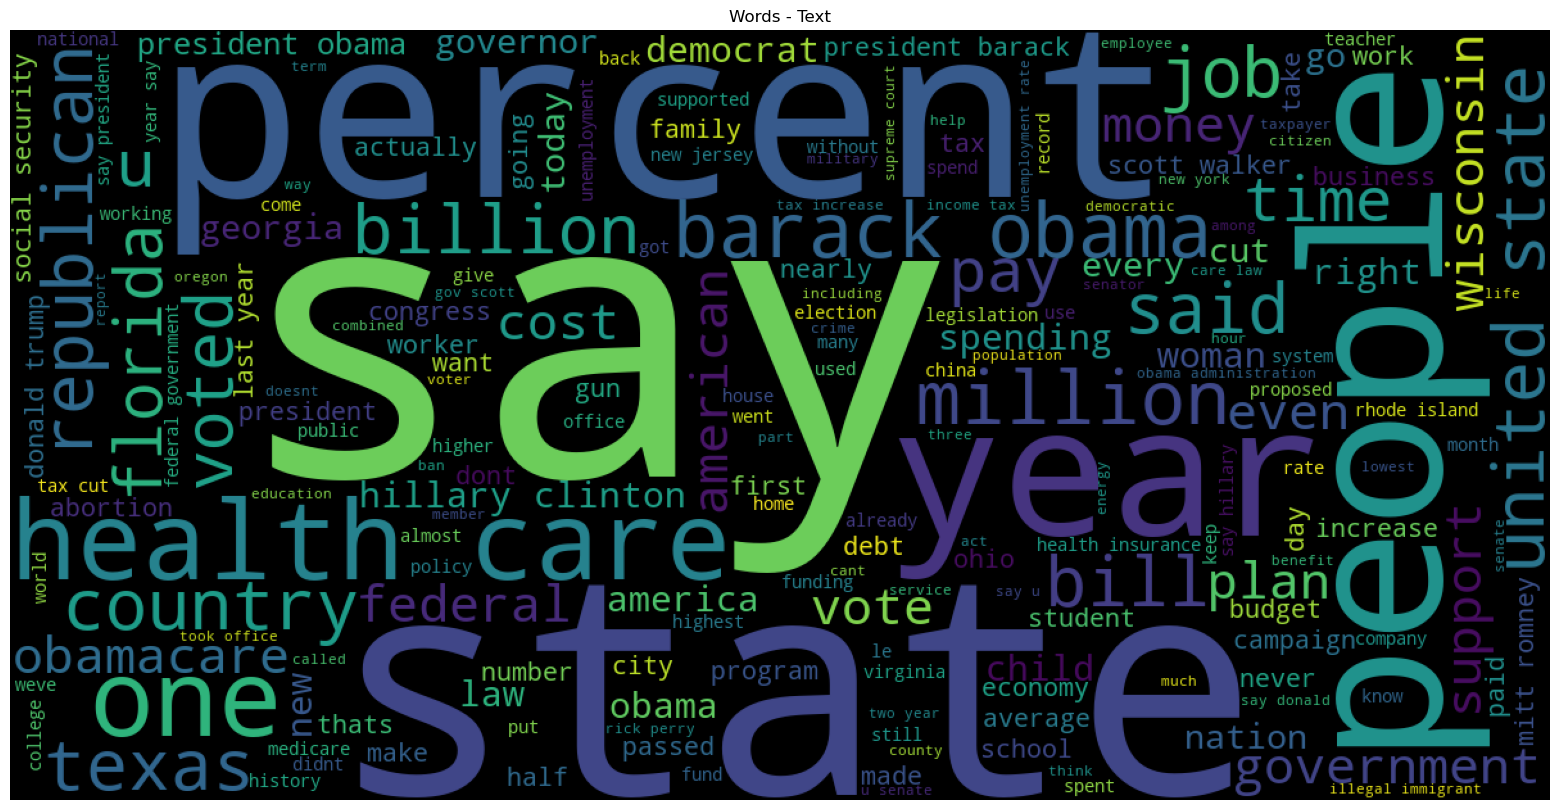

In [6]:
words_text = " ".join([word for word_list in data["Text_tokens"] for word in word_list]) #word cloud for text
word_cloud_text = WordCloud(width=1200, height=600).generate(words_text)
plt.figure(figsize=(20, 10))
plt.imshow(word_cloud_text)
plt.title("Words - Text")
plt.axis("off")
plt.show()

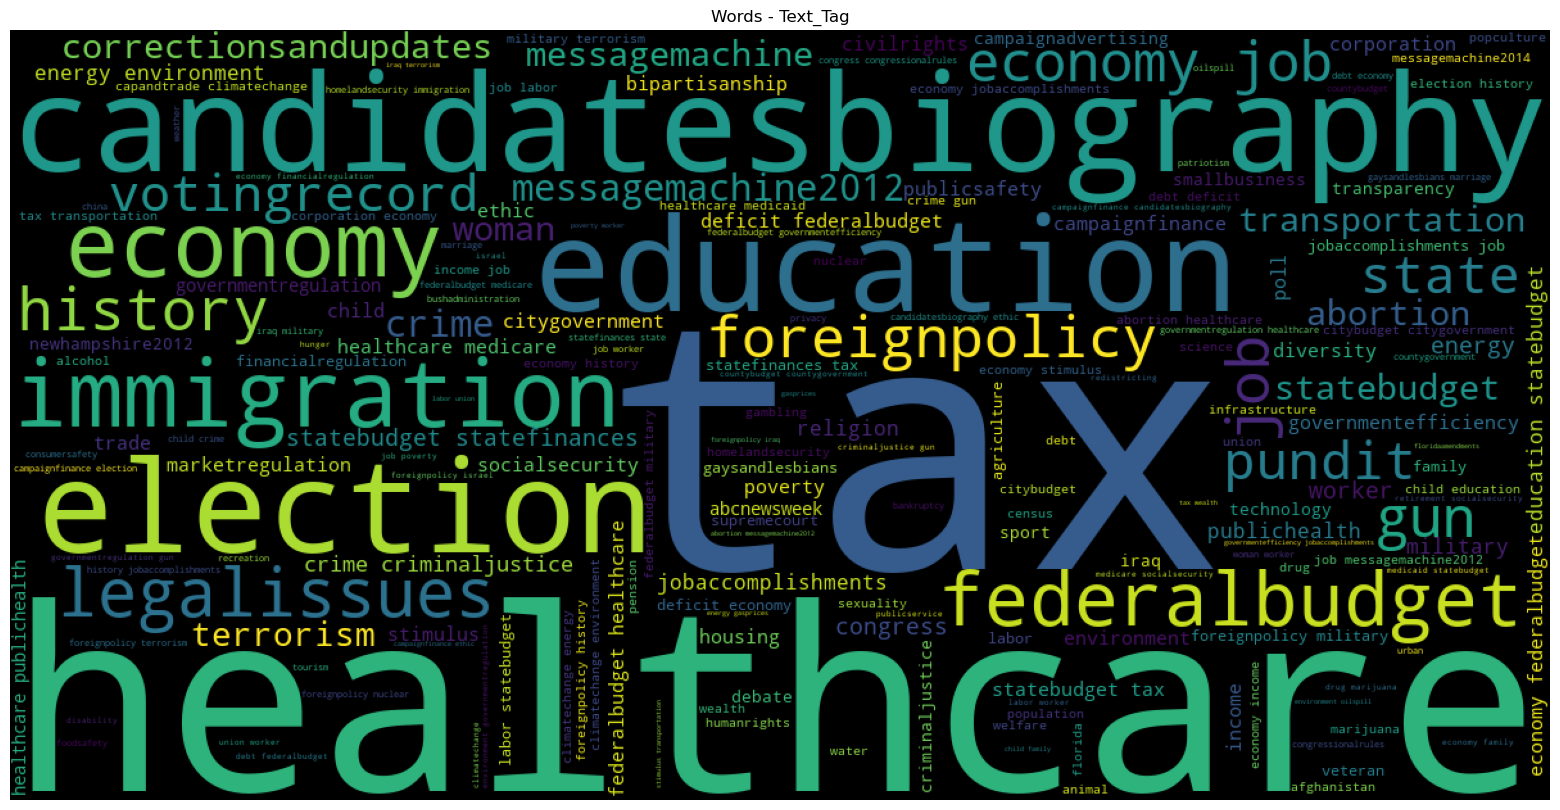

In [7]:
words_tags = " ".join([tag for tag_list in data["Text_Tag_tokens"] for each_tag in tag_list for tag in each_tag]) #word cloud for tags
word_cloud_tags = WordCloud(width=1200, height=600).generate(words_tags)
plt.figure(figsize=(20, 10))
plt.imshow(word_cloud_tags)
plt.title("Words - Text_Tag")
plt.axis("off")
plt.show()

d:\Anaconda\envs\ds\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


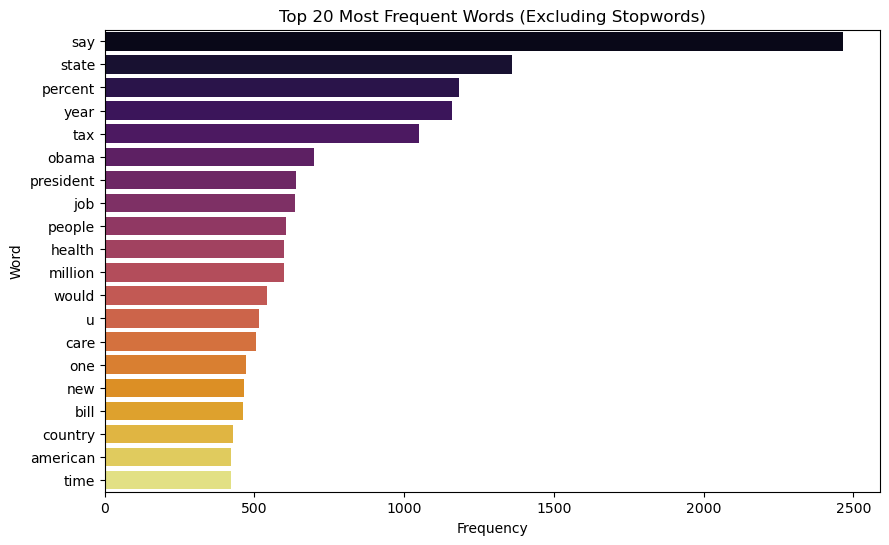

In [8]:
#graph to show the most common words
vectorizer = CountVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x)
X = vectorizer.fit_transform(data['Text_tokens'])

word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

word_freq_sum = word_freq.sum(axis=0).sort_values(ascending=False)[:20]
plt.figure(figsize=(10, 6))
sns.barplot(x=word_freq_sum.values, y=word_freq_sum.index, palette='inferno')
plt.title('Top 20 Most Frequent Words (Excluding Stopwords)')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

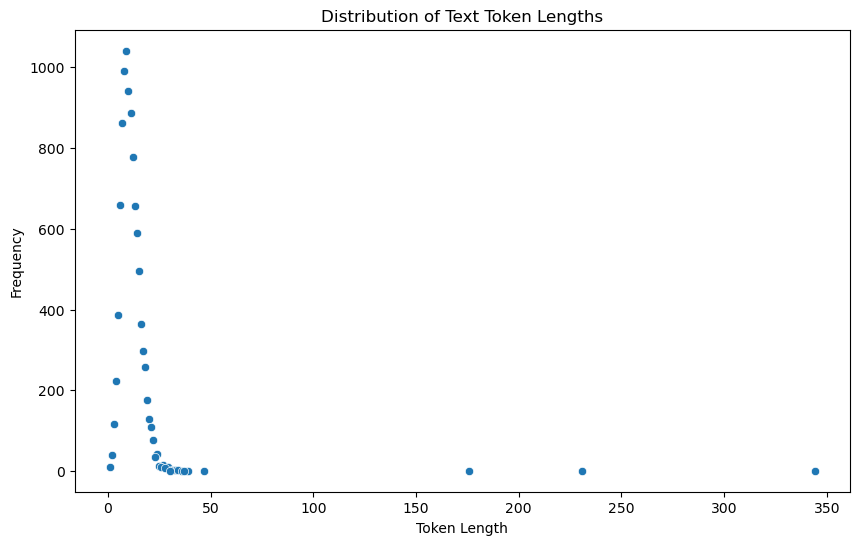

In [9]:
text_token_lengths = data['Text_tokens'].apply(len) #graph to show distribution of token lengths
plt.figure(figsize=(10, 6))
sns.scatterplot(text_token_lengths.value_counts())
plt.title('Distribution of Text Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()

In [10]:
x_train, x_test, y_train, y_test = train_test_split(data['Text_tokens'], data['Labels'], test_size=0.2) #train test split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [17]:
vec_size = 100 #we will embed words into a 100-dimensional vector space.

embedding_model = Word2Vec(sentences=corpus, vector_size=vec_size, window=5, min_count=1, workers=4)
embedding_model.build_vocab(x_train, update=True)

max_length = text_token_lengths.value_counts().index.max() + 1 #pad sentences till this length.
padding = np.zeros((1,vec_size)) #the vector to pad sentences with.
word2idx = {word: embedding_model.wv.key_to_index[word] for word in embedding_model.wv.key_to_index} #word to index mapping

In [18]:
#the algorithm to embed and pad sentences.
def embed_and_pad_words(word_list):
    sequences = []
    for sentence in word_list:
        tokens = []
        for token in sentence:
            try:
                tokens.append(word2idx[token])
            except KeyError:
                continue
        sequences.append(tokens)
        
    # Pad sequences
    padded_sequences = []
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

    # Replace tokens with embeddings
    embedded_sequences = []
    embedded_sequences = np.array([embedding_model.wv[embedding_model.wv.index_to_key[idx]] for idx in padded_sequences.flatten()])
    embedded_sequences = embedded_sequences.reshape(padded_sequences.shape + (vec_size,))
    
    return embedded_sequences

In [22]:
x_train = embed_and_pad_words(x_train) #embedding and padding the sentences. expect these to take as much time as an actual ml model training bruh

x_test = embed_and_pad_words(x_test)

x_val = embed_and_pad_words(x_val)

In [23]:
#the ml model needs input and output to be a list.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [24]:

#here begins the model!

model = keras.Sequential() #this will be a sequential model.

model.add(keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2]))) #input layer- shape equal to the shape of matrix containing a sentence.

model.add(keras.layers.Masking(mask_value=0.)) #masking layer to ignore padding.

model.add(keras.layers.Bidirectional(keras.layers.LSTM(100))) #bidirectional LSTM, output will be a 64-dim vector for each word in the sentence.

model.add(keras.layers.Dense(64, activation='relu')) #dense layer with 64 units.

model.add(keras.layers.Dropout(0.5)) #dropout layer to prevent overfitting.

model.add(keras.layers.Dense(6, activation='sigmoid')) #output layer with 5 units, one for each class.

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #compiling the model.

In [25]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=16, callbacks=[EarlyStopping(monitor='accuracy', mode='min', verbose=1, patience=20)])
#training the model. stopping early if accuracy doesn't improve for 10 epochs.

Epoch 1/100
175/410 ━━━━━━━━━━━━━━━━━━━━ 44s 191ms/step - accuracy: 0.1813 - loss: 1.8146

In [ ]:
y_pred = model.predict(x_test) #predicting the test set.
y_pred = np.argmax(y_pred, axis=1) #converting the output to a class.
y_true = np.argmax(y_test, axis=1) #converting the true output to a class.
print(classification_report(y_true, y_pred)) #printing the classification report.
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot() #plotting the confusion matrix.
plt.show() #show the plot.